In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator
sns.set(style="ticks", font_scale=2)

## Weather Data

In [2]:
'''
Daily weather data at CYUL

Read in list of csvs and concatenate dataframes of each
'''
daily_files = glob.glob("./weather_data/daily/"+"eng-daily-010120*.csv")
dataframes = []
for fi in daily_files:
    df = pd.read_csv(fi,skiprows=24, parse_dates=[0], index_col=None)
    dataframes.append(df)
    
yul_wx = pd.concat(dataframes)
yul_wx.set_index('Date/Time',inplace=True)
yul_wx.sort_index(inplace=True)
#Remove days with missing max temp data
yul_wx = yul_wx.dropna(subset=['Max Temp (°C)'])
#Handle strings in wind data
yul_wx.loc[yul_wx['Spd of Max Gust (km/h)']=='<31','Spd of Max Gust (km/h)'] = 0
yul_wx['Spd of Max Gust (km/h)'] = yul_wx['Spd of Max Gust (km/h)'].astype(float)
#Qualatative info
yul_wx.loc[yul_wx['Total Precip (mm)']==0, 'Wet'] = False
yul_wx.loc[yul_wx['Total Precip (mm)']>0, 'Wet'] = True
yul_wx.loc[yul_wx['Total Snow (cm)']==0, 'Snowy'] = False
yul_wx.loc[yul_wx['Total Snow (cm)']>0, 'Snowy'] = True
yul_wx.loc[yul_wx['Total Precip (mm)']==0, 'Rainy'] = False
yul_wx.loc[yul_wx['Total Precip (mm)']>0, 'Rainy'] = True

In [3]:
'''
Hourly weather data at CYUL
'''
hourly_files = glob.glob("./weather_data/hourly/"+"eng-hourly*.csv")
yul_hourly = pd.DataFrame()
dataframes = []
for fi in hourly_files:
    df = pd.read_csv(fi,index_col=None, skiprows=15,parse_dates=['Date/Time'])
    dataframes.append(df)
    
yul_hourly = pd.concat(dataframes)
yul_hourly.set_index('Date/Time',inplace=True)
yul_hourly.sort_index(inplace=True)

# Bixi Data

In [4]:
#List of stations
stations = pd.read_csv('./bixi_data/station_lists/Stations_2017.csv', index_col=0)

#Get trip info
bixi_files = glob.glob("./bixi_data/"+"OD*.csv")
bixi = pd.DataFrame()
dataframes = []
for fi in bixi_files:
    df = pd.read_csv(fi,index_col=None, header=0)
    dataframes.append(df)
bixi = pd.concat(dataframes)

#Parse out date/time information
bixi['start_date'] = pd.to_datetime(bixi.start_date)
bixi['end_date'] = pd.to_datetime(bixi.end_date)
bixi.sort_values('start_date',inplace=True)
bixi['month'] = bixi.start_date.dt.month
bixi['year'] = bixi.start_date.dt.year
bixi['weekofyear'] = bixi.start_date.dt.weekofyear
bixi['hour'] = bixi.start_date.dt.hour
bixi['day'] = bixi.start_date.dt.day

### Daily bixi data

In [8]:
bixi_per_day = pd.DataFrame(bixi.groupby(bixi.start_date.dt.date).end_date.count())
bixi_per_day.reset_index(inplace=True)
bixi_per_day['start_date'] = pd.to_datetime(bixi_per_day['start_date'],format="%Y-%m-%d")
bixi_per_day.set_index('start_date', inplace=True)
bixi_per_day.rename(columns={'end_date':'count'}, inplace=True)

#Add in weather data
bixi_per_day['Tmax'] = yul_wx['Max Temp (°C)']
bixi_per_day['Tmin'] = yul_wx['Min Temp (°C)']
bixi_per_day['Precip'] = yul_wx['Total Precip (mm)']
bixi_per_day['Wet'] = yul_wx['Wet']

bixi_per_day['year'] = bixi_per_day.index.year
bixi_per_day['month'] = bixi_per_day.index.month
bixi_per_day['day'] = bixi_per_day.index.day
bixi_per_day['Gust'] = yul_wx['Spd of Max Gust (km/h)']


Text(0.5,1.05,'Daily Maximum Temperature vs. Bixi Trips (2017)')

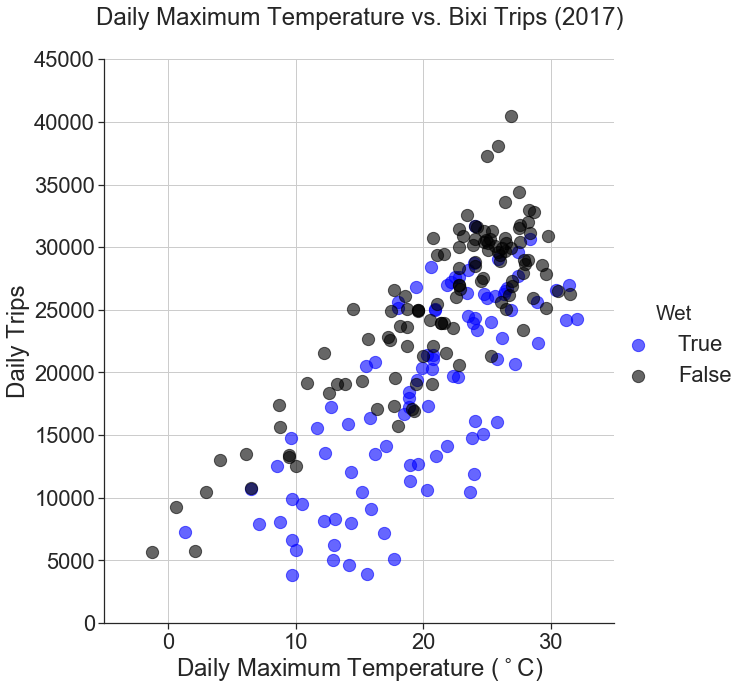

In [11]:
g=sns.lmplot(x='Tmax',y='count' ,
             data=bixi_per_day[(bixi_per_day.year==2017)], 
             hue='Wet', hue_order=[True, False], palette={True:'blue',False:'black'},
             height=9, scatter_kws={"s": 150, 'alpha':0.6},
             fit_reg=False)
plt.ylim([0,45000])
plt.xlim([-5,35])
plt.grid()
g.set_axis_labels("Daily Maximum Temperature ($^\circ$C)", "Daily Trips")
plt.title('Daily Maximum Temperature vs. Bixi Trips (2017)', y=1.05)

/aos/home/cmccray/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


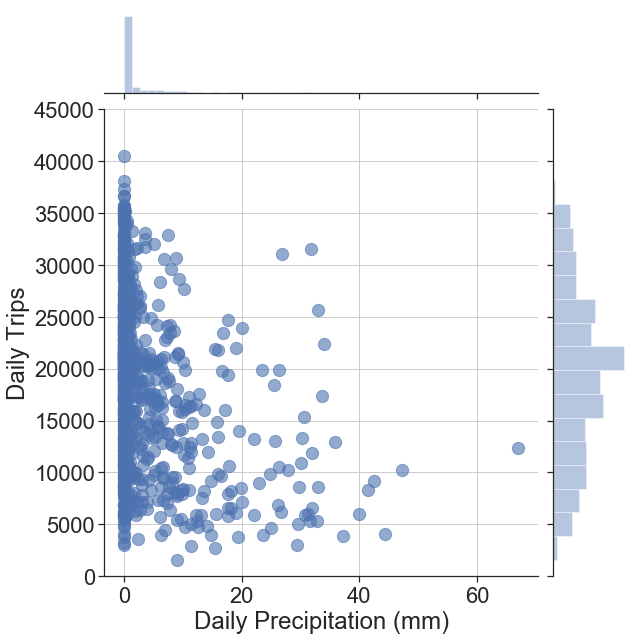

In [19]:
g = sns.jointplot("Precip", "count", 
                   data=bixi_per_day, ylim=[0,45000], 
                  height=9, joint_kws={"s": 150, 'alpha':0.6})
g.ax_joint.grid()
g.set_axis_labels("Daily Precipitation (mm)", "Daily Trips")

## Resample data to 10 min intervals

In [20]:
#Resample to 10 min intervals
bixi_10m  = bixi.set_index('start_date').resample('10T', label='left').count().fillna(0)
bixi_10m['time'] = bixi_10m.index.time
bixi_10m['month'] = bixi_10m.index.month
bixi_10m['hour'] = bixi_10m.index.hour
bixi_10m['year'] = bixi_10m.index.year
bixi_10m['day'] = bixi_10m.index.day

In [23]:
'''
Get median trip counts every 10 m for weekends and weekdays in 2017
'''
year=2017
median_weekday_10m  = pd.DataFrame(bixi_10m[(bixi_10m.index.dayofweek<=4) &(bixi_10m.index.year==year)&
        (bixi_10m.index.month>5) & (bixi_10m.index.month<10)].groupby('time').median()['start_station_code'])
median_weekend_10m = pd.DataFrame(bixi_10m[(bixi_10m.index.dayofweek>4) &(bixi_10m.index.year==year)&
        (bixi_10m.index.month>5) & (bixi_10m.index.month<10)].groupby('time').median()['start_station_code'])
median_weekday_10m.rename(columns={"start_station_code": "trips"} , inplace=True)
median_weekend_10m.rename(columns={"start_station_code": "trips"} , inplace=True)

Text(0.5,1.04,'Median Bixi trips started by 10-min interval (June-Sept 2017)')

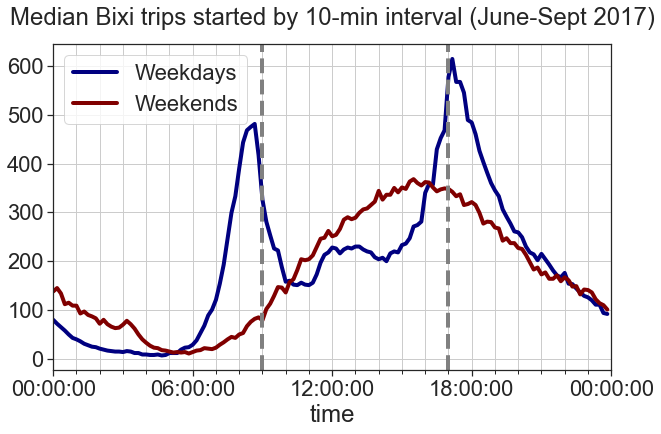

In [24]:
fig, ax = plt.subplots(figsize=[10,6])
median_weekday_10m['trips'].plot(color='navy',label='Weekdays', lw=4, ax=ax)
median_weekend_10m['trips'].plot(color='maroon', label='Weekends', lw=4, ax=ax)

ax.axvline('9:00', lw=4, ls='--', c = 'gray')
ax.axvline('17:00', lw=4, ls='--', c = 'gray')
ax.set_xticks(np.arange(0,86401,21600))
ax.xaxis.set_minor_locator(FixedLocator(np.arange(0,86401,3600)))
ax.set_xlim([0,86400])

plt.legend()
plt.grid(which="both")
plt.title('Median Bixi trips started by 10-min interval (June-Sept 2017)',y=1.04)


## Compare 10 m data with weather data

In [25]:
yul_hourly.loc['2017-07-31']['Weather']

Date/Time
2017-07-31 00:00:00                           NaN
2017-07-31 01:00:00                 Mostly Cloudy
2017-07-31 02:00:00                           NaN
2017-07-31 03:00:00                           NaN
2017-07-31 04:00:00                        Cloudy
2017-07-31 05:00:00                           NaN
2017-07-31 06:00:00                           NaN
2017-07-31 07:00:00                  Mainly Clear
2017-07-31 08:00:00                           NaN
2017-07-31 09:00:00                           NaN
2017-07-31 10:00:00                 Mostly Cloudy
2017-07-31 11:00:00                           NaN
2017-07-31 12:00:00                           NaN
2017-07-31 13:00:00                  Mainly Clear
2017-07-31 14:00:00                           NaN
2017-07-31 15:00:00                 Thunderstorms
2017-07-31 16:00:00    Thunderstorms,Rain Showers
2017-07-31 17:00:00                           NaN
2017-07-31 18:00:00                           NaN
2017-07-31 19:00:00                  Mai

Text(0.5,1,'10-min Bixi Trips - 31 July 2017 vs. Median')

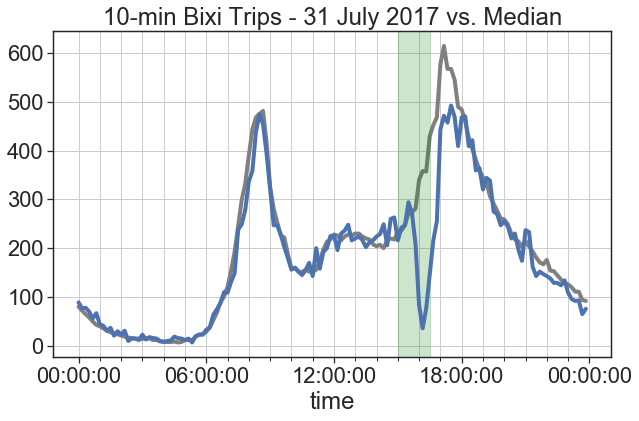

In [26]:
fig = plt.figure(figsize=[10,6])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
#Plot median on one axis
ax1.plot(median_weekday_10m, color='gray', lw=4, label='Average')
#Plot actual values on second axis
ax2.plot(bixi_10m.loc['2017-07-31']['start_station_code'], lw=4,label='Actual')

#Turn off second axis so only times are visible
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

#Fill in rainy period
ax2.axvspan('2017-07-31 15:00:00','2017-07-31 16:30:00', alpha=0.2, color='green')
#Label every six hours
ax1.set_xticks(np.arange(0,86401,21600))
ax1.xaxis.set_minor_locator(FixedLocator(np.arange(0,86401,3600)))

ax1.grid(which="both")

plt.title('10-min Bixi Trips - 31 July 2017 vs. Median')

# Bike Counter Data

In [27]:
dataframes = []
counter_files = glob.glob("./bike_counter_data/"+"comptagevelo*.csv")
for fi in counter_files:
    df = pd.read_csv(fi,index_col=None, header=0)
    dataframes.append(df)
comptage = pd.concat(dataframes)
comptage['Date'] = pd.to_datetime(comptage.Date, dayfirst=True)
comptage.set_index('Date', inplace=True)
comptage['total'] = comptage.sum(axis=1)
comptage=comptage.drop('Unnamed: 1', axis=1)
comptage['year'] = comptage.index.year
comptage['month'] = comptage.index.month
comptage['day'] = comptage.index.day

#Add in weather data
comptage['Tmax'] = yul_wx['Max Temp (°C)']
comptage['Tmin'] = yul_wx['Min Temp (°C)']
comptage['Tmean'] = yul_wx['Mean Temp (°C)']
comptage['Snow'] = yul_wx['Total Snow (cm)']
comptage['Precip'] = yul_wx['Total Precip (mm)']
comptage['Rain'] = yul_wx['Total Rain (mm)']
comptage['Gust'] = yul_wx['Spd of Max Gust (km/h)']
comptage['Snowcover'] = yul_wx['Snow on Grnd (cm)']
comptage['Wet'] = yul_wx['Wet']
#Get data for a few reliable stations
comptage['reliable_total'] = comptage[comptage.year>=2015][['Parc', 'PierDup', 'CSC (Côte Sainte-Catherine)', 'Brébeuf','Notre-Dame', 'Boyer', 'Saint-Urbain']].sum(axis=1) 
comptage.loc[comptage.index.weekday<5, 'weekday'] = 'weekday'
comptage.loc[comptage.index.weekday>=5, 'weekday'] = 'weekend'

Text(0.5,1.05,'Montreal - Daily Max Temperature vs. Bikes Counted\n2015-2017')

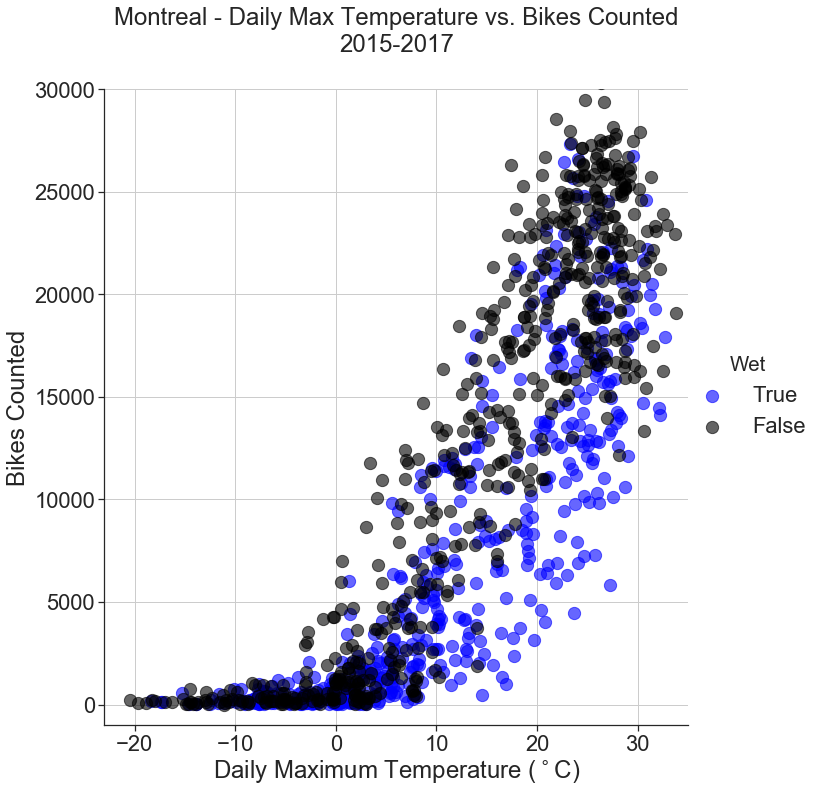

In [35]:
ax = sns.lmplot("Tmax", "reliable_total", 
                   data=comptage[(comptage.year>=2015) & (comptage.Wet!='red')], scatter_kws={"s": 150, 'alpha':0.6}, 
                hue='Wet',height=10,fit_reg=False,
                hue_order=[True, False], palette={True:'blue',False:'black'},)
plt.ylim([-1000,30000])
plt.xlim([-23,35])
plt.grid()
ax.set_axis_labels("Daily Maximum Temperature ($^\circ$C)", "Bikes Counted")

plt.title('Montreal - Daily Max Temperature vs. Bikes Counted\n2015-2017', y=1.05)